In [1]:
!pip install mediapipe opencv-python

import sys
sys.version

import cv2
import mediapipe as mp
import numpy as np
mp_drawing = mp.solutions.drawing_utils
mp_pose = mp.solutions.pose

In [2]:
def calculate_angle(a,b,c):
    a = np.array(a) # First
    b = np.array(b) # Mid
    c = np.array(c) # End
    
    radians = np.arctan2(c[1]-b[1], c[0]-b[0]) - np.arctan2(a[1]-b[1], a[0]-b[0])
    angle = np.abs(radians*180.0/np.pi)
    
    if angle >180.0:
        angle = 360-angle
        
    return round(angle) 

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 상체, 발목 각도
cap1 = cv2.VideoCapture('./video/후면1.mp4')
cap2 = cv2.VideoCapture('./video/측면1.mp4')
fd_back1 = None
fd_back2 = None
angle1_lst = []
angle2_lst = []
diff_angle_lst = []

## Setup mediapipe instance
with mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose:
    while cap1.isOpened() and cap2.isOpened():
        ret1, frame1 = cap1.read()
        ret2, frame2 = cap2.read()
        
        if not ret1 or not ret2:
            break
        
        # Recolor image to RGB
        image1 = cv2.cvtColor(frame1, cv2.COLOR_BGR2RGB)
        image1.flags.writeable = False

        image2 = cv2.cvtColor(frame2, cv2.COLOR_BGR2RGB)
        image2.flags.writeable = False
      
        # Make detection
        results1 = pose.process(image1)

        results2 = pose.process(image2)
    
        # Recolor back to BGR
        image1.flags.writeable = True
        image1 = cv2.cvtColor(image1, cv2.COLOR_RGB2BGR)
        
        image2.flags.writeable = True
        image2 = cv2.cvtColor(image2, cv2.COLOR_RGB2BGR)
        
        # Extract landmarks
        try:
            landmarks1 = results1.pose_landmarks.landmark
            
            # 발목
            # 좌표
            knee1 = [landmarks1[mp_pose.PoseLandmark.RIGHT_KNEE.value].x,landmarks1[mp_pose.PoseLandmark.RIGHT_KNEE.value].y]
            ankle1 = [landmarks1[mp_pose.PoseLandmark.RIGHT_ANKLE.value].x,landmarks1[mp_pose.PoseLandmark.RIGHT_ANKLE.value].y]
            foot1 = [landmarks1[mp_pose.PoseLandmark.RIGHT_FOOT_INDEX.value].x,landmarks1[mp_pose.PoseLandmark.RIGHT_FOOT_INDEX.value].y]
            
            # 각도
            angle1 = calculate_angle(knee1, ankle1, foot1)
            

            
            # 각도 시각화
            cv2.rectangle(image1, (0,0), (225,73), (245,117,16), -1)

            cv2.putText(image1, 'Angle', (20,12), 
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,0), 1, cv2.LINE_AA)
            cv2.putText(image1, str(angle1), 
                        (10,60), 
                        cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
            
            if angle1 > 120:
                fd_back1 = "good"
            if angle1 <= 120:
                fd_back1="bad"
            
            landmarks2 = results2.pose_landmarks.landmark
            
            # 발목
            # 좌표
            knee2 = [landmarks2[mp_pose.PoseLandmark.RIGHT_KNEE.value].x,landmarks2[mp_pose.PoseLandmark.RIGHT_KNEE.value].y]
            ankle2 = [landmarks2[mp_pose.PoseLandmark.RIGHT_ANKLE.value].x,landmarks2[mp_pose.PoseLandmark.RIGHT_ANKLE.value].y]
            foot2 = [landmarks2[mp_pose.PoseLandmark.RIGHT_FOOT_INDEX.value].x,landmarks2[mp_pose.PoseLandmark.RIGHT_FOOT_INDEX.value].y]
            
            # 각도
            angle2 = calculate_angle(knee2, ankle2, foot2)
            
            
            # 각도 시각화
            cv2.rectangle(image2, (0,0), (225,73), (245,117,16), -1)

            cv2.putText(image2, 'Angle', (20,12), 
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,0), 1, cv2.LINE_AA)
            cv2.putText(image2, str(angle2), 
                        (10,60), 
                        cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
            
            if angle2 > 120:
                fd_back1 = "good"
            if angle2 <= 120:
                fd_back1="bad"
                
            # 각도 차 계산
            
            diff_angle = abs(angle2 - angle1)
            
            cv2.rectangle(image2, (255,0), (510,73), (245,117,16), -1)

            cv2.putText(image2, 'diff_angle', (350,12), 
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,0), 1, cv2.LINE_AA)
            cv2.putText(image2, str(diff_angle), 
                        (350,60), 
                        cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
            
            if abs(diff_angle) < 10:
                angle1_lst.append(angle1)
                angle2_lst.append(angle2)
                diff_angle_lst.append(diff_angle)
            

                       
        except:
            pass
        
        
        # Render detections
        mp_drawing.draw_landmarks(image1, results1.pose_landmarks, mp_pose.POSE_CONNECTIONS,
                                mp_drawing.DrawingSpec(color=(255,0,0), thickness=2, circle_radius=2), 
                                mp_drawing.DrawingSpec(color=(255,144,30), thickness=2, circle_radius=2)  
                                 )
        
        mp_drawing.draw_landmarks(image2, results2.pose_landmarks, mp_pose.POSE_CONNECTIONS,
                                mp_drawing.DrawingSpec(color=(255,0,0), thickness=2, circle_radius=2), 
                                mp_drawing.DrawingSpec(color=(255,144,30), thickness=2, circle_radius=2)  
                                 )
        
        if fd_back1 == 'bad':
            if results1.pose_landmarks:
                # 왼쪽 어깨, 팔꿈치, 손목의 랜드마크 인덱스
                right_ankle_landmarks1 = [mp_pose.PoseLandmark.RIGHT_KNEE,
                                      mp_pose.PoseLandmark.RIGHT_ANKLE,
                                      mp_pose.PoseLandmark.RIGHT_FOOT_INDEX]

                # 왼팔의 점을 빨간색으로 그리기
                for landmark in right_ankle_landmarks1:
                    landmark_px = results1.pose_landmarks.landmark[landmark]
                    x_px, y_px = int(landmark_px.x * image1.shape[1]), int(landmark_px.y * image1.shape[0])
                    cv2.circle(image1, (x_px, y_px), 5, (0, 0, 255), -1)

                # 왼팔을 이어주는 선 그리기
                cv2.line(image1, (int(results1.pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_KNEE].x * image1.shape[1]),
                                 int(results1.pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_KNEE].y * image1.shape[0])),
                         (int(results1.pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_ANKLE].x * image1.shape[1]),
                          int(results1.pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_ANKLE].y * image1.shape[0])), (0, 0, 255), 2)
                cv2.line(image1, (int(results1.pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_ANKLE].x * image1.shape[1]),
                                 int(results1.pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_ANKLE].y * image1.shape[0])),
                         (int(results1.pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_FOOT_INDEX].x * image1.shape[1]),
                          int(results1.pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_FOOT_INDEX].y * image1.shape[0])), (0, 0, 255), 2)


        if fd_back2 == 'bad':
            if results2.pose_landmarks:
                # 왼쪽 어깨, 팔꿈치, 손목의 랜드마크 인덱스
                right_ankle_landmarks2 = [mp_pose.PoseLandmark.RIGHT_KNEE,
                                      mp_pose.PoseLandmark.RIGHT_ANKLE,
                                      mp_pose.PoseLandmark.RIGHT_FOOT_INDEX]

                # 왼팔의 점을 빨간색으로 그리기
                for landmark in right_ankle_landmarks2:
                    landmark_px = results2.pose_landmarks.landmark[landmark]
                    x_px, y_px = int(landmark_px.x * image2.shape[1]), int(landmark_px.y * image2.shape[0])
                    cv2.circle(image2, (x_px, y_px), 5, (0, 0, 255), -1)

                # 왼팔을 이어주는 선 그리기
                cv2.line(image2, (int(results2.pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_KNEE].x * image2.shape[1]),
                                 int(results2.pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_KNEE].y * image2.shape[0])),
                         (int(results2.pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_ANKLE].x * image2.shape[1]),
                          int(results2.pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_ANKLE].y * image2.shape[0])), (0, 0, 255), 2)
                cv2.line(image2, (int(results2.pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_ANKLE].x * image2.shape[1]),
                                 int(results2.pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_ANKLE].y * image2.shape[0])),
                         (int(results2.pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_FOOT_INDEX].x * image2.shape[1]),
                          int(results2.pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_FOOT_INDEX].y * image2.shape[0])), (0, 0, 255), 2)

        cv2.imshow("Camera 1", image1)
        cv2.imshow("Camera 2", image2)

        if cv2.waitKey(100) & 0xFF == ord('q'):
            break

    cap1.release()
    cap2.release()
    cv2.destroyAllWindows()

In [4]:
df = pd.DataFrame({'back' : angle1_lst, 'side' : angle2_lst, 'angle_sub' : diff_angle_lst})
df.loc['avg'] = [abs(np.mean(angle1_lst)), abs(np.mean(angle2_lst)), abs(np.mean(diff_angle_lst))]
df

,back,side,angle_sub
0,146.0,150.0,4.0
1,132.0,128.0,4.0
2,126.0,133.0,7.0
3,134.0,125.0,9.0
4,121.0,121.0,0.0
avg,131.8,131.4,4.8


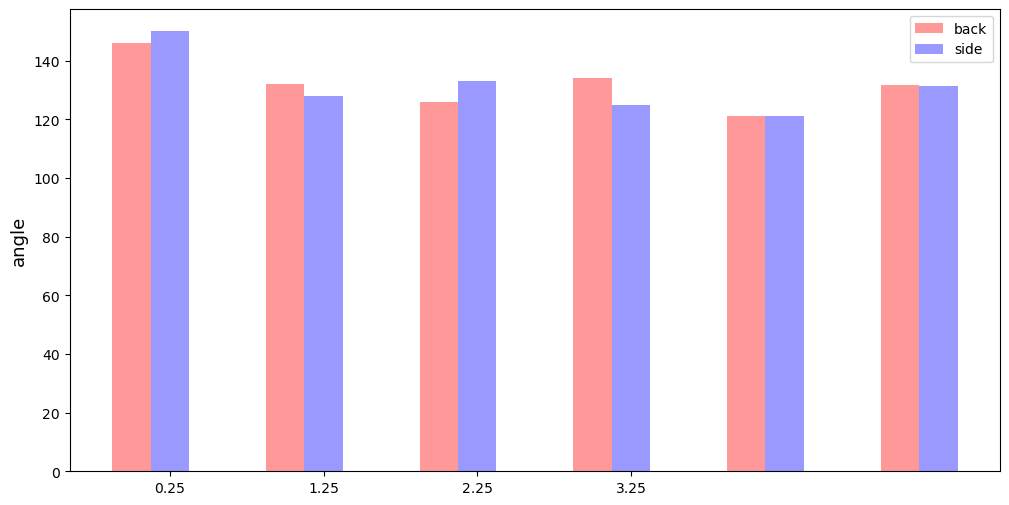

In [5]:
# 그림 사이즈, 바 굵기 조정
fig, ax = plt.subplots(figsize=(12,6))
bar_width = 0.25

# 연도가 4개이므로 0, 1, 2, 3 위치를 기준으로 삼음
index = np.arange(6)

# 각 연도별로 3개 샵의 bar를 순서대로 나타내는 과정, 각 그래프는 0.25의 간격을 두고 그려짐
b1 = plt.bar(index, df['back'], bar_width, alpha=0.4, color='red', label='back')

b2 = plt.bar(index + bar_width, df['side'], bar_width, alpha=0.4, color='blue', label='side')

#b3 = plt.bar(index + 2 * bar_width, df['angle_sub'], bar_width, alpha=0.4, color='green', label='angle_sub')

# x축 위치를 정 가운데로 조정하고 x축의 텍스트를 year 정보와 매칭
plt.xticks(np.arange(bar_width, 4 + bar_width, 1))

# x축, y축 이름 및 범례 설정
#plt.xlabel('year', size = 13)
plt.ylabel('angle', size = 13)
plt.legend()
plt.show()

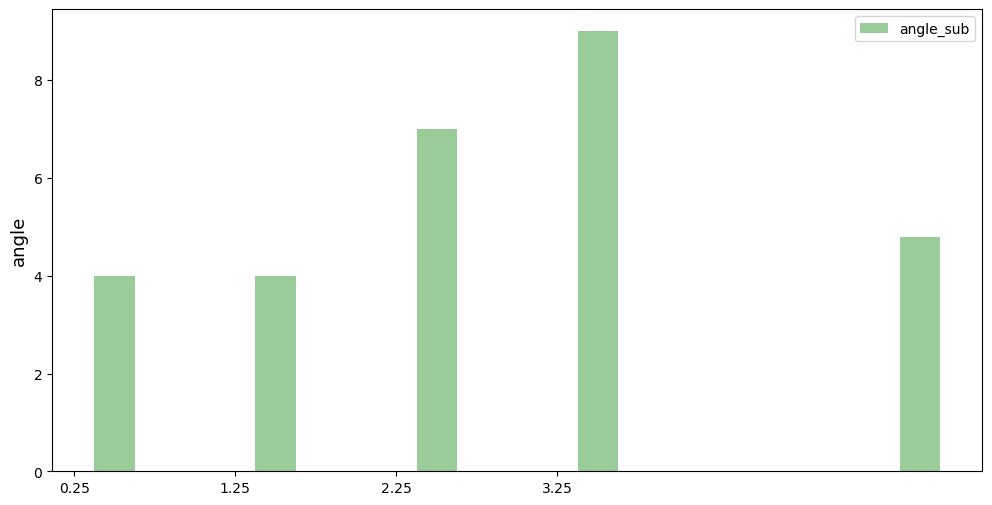

In [6]:
# 그림 사이즈, 바 굵기 조정
fig, ax = plt.subplots(figsize=(12,6))
bar_width = 0.25

# 연도가 4개이므로 0, 1, 2, 3 위치를 기준으로 삼음
index = np.arange(6)

# 각 연도별로 3개 샵의 bar를 순서대로 나타내는 과정, 각 그래프는 0.25의 간격을 두고 그려짐
#b1 = plt.bar(index, df['back'], bar_width, alpha=0.4, color='red', label='back')

#b2 = plt.bar(index + bar_width, df['side'], bar_width, alpha=0.4, color='blue', label='side')

b3 = plt.bar(index + 2 * bar_width, df['angle_sub'], bar_width, alpha=0.4, color='green', label='angle_sub')

# x축 위치를 정 가운데로 조정하고 x축의 텍스트를 year 정보와 매칭
plt.xticks(np.arange(bar_width, 4 + bar_width, 1))

# x축, y축 이름 및 범례 설정
#plt.xlabel('year', size = 13)
plt.ylabel('angle', size = 13)
plt.legend()
plt.show()

In [8]:
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 상체, 발목 각도
cap1 = cv2.VideoCapture('./video/전면10.mp4')
cap2 = cv2.VideoCapture('./video/측면10.mp4')
fd_back1 = None
fd_back2 = None
angle1_lst = []
angle2_lst = []
diff_angle_lst = []

## Setup mediapipe instance
with mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose:
    while cap1.isOpened() and cap2.isOpened():
        ret1, frame1 = cap1.read()
        ret2, frame2 = cap2.read()
        
        if not ret1 or not ret2:
            break
        
        # Recolor image to RGB
        image1 = cv2.cvtColor(frame1, cv2.COLOR_BGR2RGB)
        image1.flags.writeable = False

        image2 = cv2.cvtColor(frame2, cv2.COLOR_BGR2RGB)
        image2.flags.writeable = False
      
        # Make detection
        results1 = pose.process(image1)

        results2 = pose.process(image2)
    
        # Recolor back to BGR
        image1.flags.writeable = True
        image1 = cv2.cvtColor(image1, cv2.COLOR_RGB2BGR)
        
        image2.flags.writeable = True
        image2 = cv2.cvtColor(image2, cv2.COLOR_RGB2BGR)
        
        # Extract landmarks
        try:
            landmarks1 = results1.pose_landmarks.landmark
            
            # 발목
            # 좌표
            knee1 = [landmarks1[mp_pose.PoseLandmark.RIGHT_KNEE.value].x,landmarks1[mp_pose.PoseLandmark.RIGHT_KNEE.value].y]
            ankle1 = [landmarks1[mp_pose.PoseLandmark.RIGHT_ANKLE.value].x,landmarks1[mp_pose.PoseLandmark.RIGHT_ANKLE.value].y]
            foot1 = [landmarks1[mp_pose.PoseLandmark.RIGHT_FOOT_INDEX.value].x,landmarks1[mp_pose.PoseLandmark.RIGHT_FOOT_INDEX.value].y]
            
            # 각도
            angle1 = calculate_angle(knee1, ankle1, foot1)
            

            
            # 각도 시각화
            cv2.rectangle(image1, (0,0), (225,73), (245,117,16), -1)

            cv2.putText(image1, 'Angle', (20,12), 
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,0), 1, cv2.LINE_AA)
            cv2.putText(image1, str(angle1), 
                        (10,60), 
                        cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
            
            if angle1 > 120:
                fd_back1 = "good"
            if angle1 <= 120:
                fd_back1="bad"
            
            landmarks2 = results2.pose_landmarks.landmark
            
            # 발목
            # 좌표
            knee2 = [landmarks2[mp_pose.PoseLandmark.RIGHT_KNEE.value].x,landmarks2[mp_pose.PoseLandmark.RIGHT_KNEE.value].y]
            ankle2 = [landmarks2[mp_pose.PoseLandmark.RIGHT_ANKLE.value].x,landmarks2[mp_pose.PoseLandmark.RIGHT_ANKLE.value].y]
            foot2 = [landmarks2[mp_pose.PoseLandmark.RIGHT_FOOT_INDEX.value].x,landmarks2[mp_pose.PoseLandmark.RIGHT_FOOT_INDEX.value].y]
            
            # 각도
            angle2 = calculate_angle(knee2, ankle2, foot2)
            
            
            # 각도 시각화
            cv2.rectangle(image2, (0,0), (225,73), (245,117,16), -1)

            cv2.putText(image2, 'Angle', (20,12), 
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,0), 1, cv2.LINE_AA)
            cv2.putText(image2, str(angle2), 
                        (10,60), 
                        cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
            
            if angle2 > 120:
                fd_back1 = "good"
            if angle2 <= 120:
                fd_back1="bad"
                
            # 각도 차 계산
            
            diff_angle = abs(angle2 - angle1)
            
            cv2.rectangle(image2, (255,0), (510,73), (245,117,16), -1)

            cv2.putText(image2, 'diff_angle', (350,12), 
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,0), 1, cv2.LINE_AA)
            cv2.putText(image2, str(diff_angle), 
                        (350,60), 
                        cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
            
            if abs(diff_angle) < 10:
                angle1_lst.append(angle1)
                angle2_lst.append(angle2)
                diff_angle_lst.append(diff_angle)


                       
        except:
            pass
        
        
        # Render detections
        mp_drawing.draw_landmarks(image1, results1.pose_landmarks, mp_pose.POSE_CONNECTIONS,
                                mp_drawing.DrawingSpec(color=(255,0,0), thickness=2, circle_radius=2), 
                                mp_drawing.DrawingSpec(color=(255,144,30), thickness=2, circle_radius=2)  
                                 )
        
        mp_drawing.draw_landmarks(image2, results2.pose_landmarks, mp_pose.POSE_CONNECTIONS,
                                mp_drawing.DrawingSpec(color=(255,0,0), thickness=2, circle_radius=2), 
                                mp_drawing.DrawingSpec(color=(255,144,30), thickness=2, circle_radius=2)  
                                 )
        
        if fd_back1 == 'bad':
            if results1.pose_landmarks:
                # 왼쪽 어깨, 팔꿈치, 손목의 랜드마크 인덱스
                right_ankle_landmarks1 = [mp_pose.PoseLandmark.RIGHT_KNEE,
                                      mp_pose.PoseLandmark.RIGHT_ANKLE,
                                      mp_pose.PoseLandmark.RIGHT_FOOT_INDEX]

                # 왼팔의 점을 빨간색으로 그리기
                for landmark in right_ankle_landmarks1:
                    landmark_px = results1.pose_landmarks.landmark[landmark]
                    x_px, y_px = int(landmark_px.x * image1.shape[1]), int(landmark_px.y * image1.shape[0])
                    cv2.circle(image1, (x_px, y_px), 5, (0, 0, 255), -1)

                # 왼팔을 이어주는 선 그리기
                cv2.line(image1, (int(results1.pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_KNEE].x * image1.shape[1]),
                                 int(results1.pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_KNEE].y * image1.shape[0])),
                         (int(results1.pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_ANKLE].x * image1.shape[1]),
                          int(results1.pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_ANKLE].y * image1.shape[0])), (0, 0, 255), 2)
                cv2.line(image1, (int(results1.pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_ANKLE].x * image1.shape[1]),
                                 int(results1.pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_ANKLE].y * image1.shape[0])),
                         (int(results1.pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_FOOT_INDEX].x * image1.shape[1]),
                          int(results1.pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_FOOT_INDEX].y * image1.shape[0])), (0, 0, 255), 2)


        if fd_back2 == 'bad':
            if results2.pose_landmarks:
                # 왼쪽 어깨, 팔꿈치, 손목의 랜드마크 인덱스
                right_ankle_landmarks2 = [mp_pose.PoseLandmark.RIGHT_KNEE,
                                      mp_pose.PoseLandmark.RIGHT_ANKLE,
                                      mp_pose.PoseLandmark.RIGHT_FOOT_INDEX]

                # 왼팔의 점을 빨간색으로 그리기
                for landmark in right_ankle_landmarks2:
                    landmark_px = results2.pose_landmarks.landmark[landmark]
                    x_px, y_px = int(landmark_px.x * image2.shape[1]), int(landmark_px.y * image2.shape[0])
                    cv2.circle(image2, (x_px, y_px), 5, (0, 0, 255), -1)

                # 왼팔을 이어주는 선 그리기
                cv2.line(image2, (int(results2.pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_KNEE].x * image2.shape[1]),
                                 int(results2.pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_KNEE].y * image2.shape[0])),
                         (int(results2.pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_ANKLE].x * image2.shape[1]),
                          int(results2.pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_ANKLE].y * image2.shape[0])), (0, 0, 255), 2)
                cv2.line(image2, (int(results2.pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_ANKLE].x * image2.shape[1]),
                                 int(results2.pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_ANKLE].y * image2.shape[0])),
                         (int(results2.pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_FOOT_INDEX].x * image2.shape[1]),
                          int(results2.pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_FOOT_INDEX].y * image2.shape[0])), (0, 0, 255), 2)

        cv2.imshow("Camera 1", image1)
        cv2.imshow("Camera 2", image2)

        if cv2.waitKey(100) & 0xFF == ord('q'):
            break

    cap1.release()
    cap2.release()
    cv2.destroyAllWindows()





In [9]:
df = pd.DataFrame({'back' : angle1_lst, 'side' : angle2_lst, 'angle_sub' : diff_angle_lst})
df.loc['avg'] = [abs(np.mean(angle1_lst)), abs(np.mean(angle2_lst)), abs(np.mean(diff_angle_lst))]
df

,back,side,angle_sub
0,135.000000,143.000000,8.000000
1,157.000000,156.000000,1.000000
2,112.000000,107.000000,5.000000
3,101.000000,103.000000,2.000000
4,110.000000,101.000000,9.000000
5,112.000000,106.000000,6.000000
6,104.000000,111.000000,7.000000
avg,118.714286,118.142857,5.428571


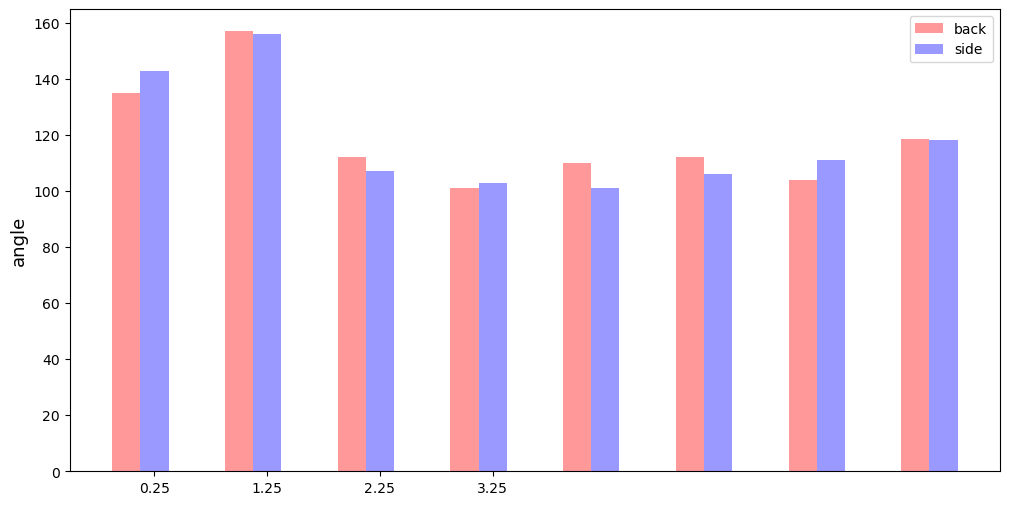

In [10]:
# 그림 사이즈, 바 굵기 조정
fig, ax = plt.subplots(figsize=(12,6))
bar_width = 0.25

# 연도가 4개이므로 0, 1, 2, 3 위치를 기준으로 삼음
index = np.arange(8)

# 각 연도별로 3개 샵의 bar를 순서대로 나타내는 과정, 각 그래프는 0.25의 간격을 두고 그려짐
b1 = plt.bar(index, df['back'], bar_width, alpha=0.4, color='red', label='back')

b2 = plt.bar(index + bar_width, df['side'], bar_width, alpha=0.4, color='blue', label='side')

#b3 = plt.bar(index + 2 * bar_width, df['angle_sub'], bar_width, alpha=0.4, color='green', label='angle_sub')

# x축 위치를 정 가운데로 조정하고 x축의 텍스트를 year 정보와 매칭
plt.xticks(np.arange(bar_width, 4 + bar_width, 1))

# x축, y축 이름 및 범례 설정
#plt.xlabel('year', size = 13)
plt.ylabel('angle', size = 13)
plt.legend()
plt.show()

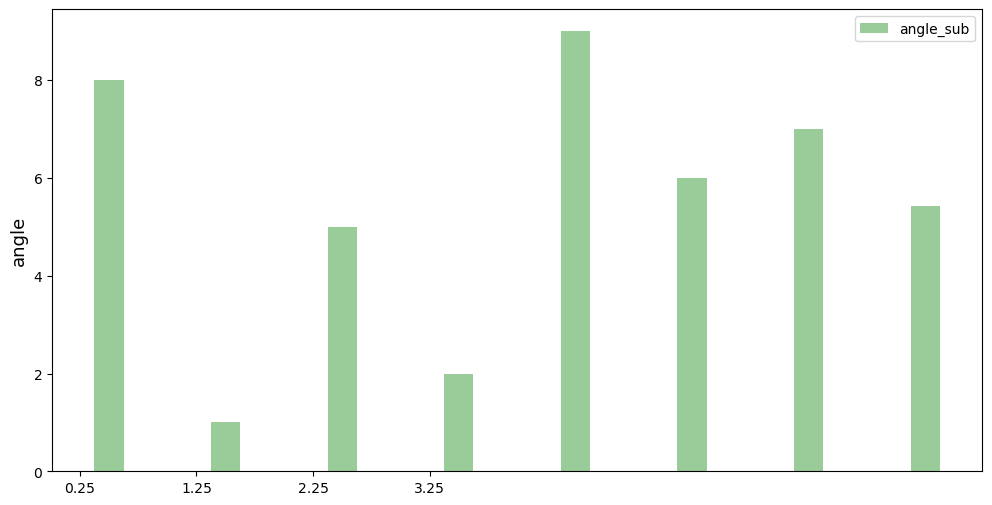

In [11]:
# 그림 사이즈, 바 굵기 조정
fig, ax = plt.subplots(figsize=(12,6))
bar_width = 0.25

# 연도가 4개이므로 0, 1, 2, 3 위치를 기준으로 삼음
index = np.arange(8)

# 각 연도별로 3개 샵의 bar를 순서대로 나타내는 과정, 각 그래프는 0.25의 간격을 두고 그려짐
#b1 = plt.bar(index, df['back'], bar_width, alpha=0.4, color='red', label='back')

#b2 = plt.bar(index + bar_width, df['side'], bar_width, alpha=0.4, color='blue', label='side')

b3 = plt.bar(index + 2 * bar_width, df['angle_sub'], bar_width, alpha=0.4, color='green', label='angle_sub')

# x축 위치를 정 가운데로 조정하고 x축의 텍스트를 year 정보와 매칭
plt.xticks(np.arange(bar_width, 4 + bar_width, 1))

# x축, y축 이름 및 범례 설정
#plt.xlabel('year', size = 13)
plt.ylabel('angle', size = 13)
plt.legend()
plt.show()